In [1]:
import os
'''
os.environ["JAX_PLATFORMS"] = "cpu"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["XLA_FLAGS"] = "--xla_cpu_multi_thread_eigen=true intra_op_parallelism_threads=128"
'''

'\nos.environ["JAX_PLATFORMS"] = "cpu"\nos.environ["CUDA_VISIBLE_DEVICES"] = ""\nos.environ["XLA_FLAGS"] = "--xla_cpu_multi_thread_eigen=true intra_op_parallelism_threads=128"\n'

In [2]:
import NSjax
import NNjax
import h5py
import json
import time
import numpy
import pyccl
import scipy
from itertools import product
from matplotlib import pyplot
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.lines as mlines
import multiprocessing
import psutil
import threading

In [3]:
# Path
folder = '/global/cfs/cdirs/lsst/groups/MCP/CosmoCloud/SOMZCloud/'
cell_folder = os.path.join(folder, 'CELL/')
info_folder = os.path.join(folder, 'INFO/')
model_folder = os.path.join(folder, 'MODEL/')
synthesize_folder = os.path.join(folder, 'SYNTHESIZE/')

tag='Y1'
typ='FIDUCIAL'
label='DOUBLE'
name='NS'

os.makedirs(os.path.join(cell_folder, '{}/'.format(tag)), exist_ok = True)
os.makedirs(os.path.join(cell_folder, '{}/{}'.format(tag, name)), exist_ok = True)

In [4]:
# Load
with h5py.File(os.path.join(synthesize_folder, '{}/{}_{}.hdf5'.format(tag, typ, label)), 'r') as file:
    data_source = file['source']['data'][...]
    data_lens = file['lens']['data'][...]
data_size, bin_source_size, z_size = data_source.shape
data_size, bin_lens_size, z_size = data_lens.shape

# Alignment
with open(os.path.join(info_folder, 'ALIGNMENT.json'), 'r') as file:
    alignment_info = json.load(file)

# Galaxy
with open(os.path.join(info_folder, 'GALAXY.json'), 'r') as file:
    galaxy_info = json.load(file)

In [5]:
# Redshift
z1 = 0.0
z2 = 3.0
z_grid = numpy.linspace(z1, z2, z_size)

In [6]:
# Cosmology
with open(os.path.join(info_folder, 'COSMOLOGY.json'), 'r') as file:
    cosmology_info = json.load(file)

Omega_m = cosmology_info['OMEGA_M']

cosmology = pyccl.Cosmology(
    h=cosmology_info['H'],
    w0=cosmology_info['W0'],
    wa=cosmology_info['WA'],
    n_s=cosmology_info['NS'], 
    A_s=cosmology_info['AS'], 
    m_nu=cosmology_info['M_NU'],
    Neff=cosmology_info['N_EFF'],
    Omega_k=cosmology_info['OMEGA_K'], 
    Omega_b=cosmology_info['OMEGA_B'], 
    Omega_c=cosmology_info['OMEGA_CDM'],
    Omega_g=cosmology_info['OMEGA_GAMMA'], 
    mass_split = 'single', matter_power_spectrum = 'halofit', transfer_function = 'boltzmann_camb',
    extra_parameters = {'camb': {'kmax': 100, 'lmax': 5000, 'halofit_version': 'mead2020_feedback', 'HMCode_logT_AGN': 7.8}}
)

    
pyccl.spline_params.N_K = z_size
pyccl.gsl_params.NZ_NORM_SPLINE_INTEGRATION = True

In [7]:
# Multipole
ell1 = 20
ell2 = 2000
ell_size = 20
ell_grid = numpy.geomspace(ell1, ell2, ell_size + 1)
ell_data = numpy.sqrt(ell_grid[+1:] * ell_grid[:-1])

LENS_PSI_GRID = numpy.mean(data_lens, axis = 0)
LENS_SIGMA_GRID = numpy.std(data_lens, axis = 0)
SOURCE_PSI_GRID = numpy.mean(data_source, axis = 0)
SOURCE_SIGMA_GRID = numpy.std(data_source, axis = 0)
A_GRID = numpy.array(1 / (1 + z_grid), dtype = 'double')

CHI_GRID = cosmology.comoving_radial_distance(a = A_GRID)
LENS_PHI_GRID = LENS_PSI_GRID * cosmology.h_over_h0(a = 1 / (1 + z_grid)) * cosmology_info['H'] * 100000 / scipy.constants.c
SOURCE_PHI_GRID = SOURCE_PSI_GRID * cosmology.h_over_h0(a = 1 / (1 + z_grid)) * cosmology_info['H'] * 100000 / scipy.constants.c


CHI_MESH, ELL_MESH = numpy.meshgrid(CHI_GRID, ell_grid)
SCALE_GRID = numpy.nan_to_num(numpy.divide(ELL_MESH + 1/2, CHI_MESH, out = numpy.zeros((ell_size + 1, z_size)) + numpy.inf, where = CHI_MESH > 0))
POWER_GRID = numpy.zeros((ell_size + 1, z_size))
for GRID_INDEX in range(z_size):

    POWER_GRID[:,GRID_INDEX] = cosmology.nonlin_matter_power(k = SCALE_GRID[:,GRID_INDEX], a = A_GRID[GRID_INDEX])
AMPLITUDE_NS = 3 / 2 * Omega_m * (cosmology_info['H'] * 100000 / scipy.constants.c)**2 * numpy.sqrt((1 + 3 / (2 * ell_grid + 1)) * (1 + 1 / (2 * ell_grid + 1)) * (1 - 1 / (2 * ell_grid + 1)) * (1 - 3 / (2 * ell_grid + 1)))
AMPLITUDE_NI = 1

In [8]:
# Define the angular power spectrum

def q_m_chi_NS(chi_data, chi_grid, phi_m_grid, type):

    phi_m = scipy.interpolate.interp1d(chi_grid, phi_m_grid, kind = type)
    
    data_size = chi_data.shape[0] - 1
    q = numpy.zeros(data_size + 1)

    for n in range(data_size + 1):
        
        function = lambda chi_prime: phi_m(chi_prime) * (chi_prime - chi_data[n]) / chi_prime
        q[n] = scipy.integrate.fixed_quad(func = function, a = chi_data[n], b = chi_grid.max(), n = 500)[0]

    return q

def c_m1_m2_NS(amplitude, phi_m1_grid, phi_m2_grid, chi_grid, power_grid, redshift_grid, type):

    a = scipy.interpolate.interp1d(chi_grid, 1 / (1 + redshift_grid), kind = type)

    pgm = scipy.interpolate.interp1d(chi_grid, power_grid, kind = type)
    
    phi_m1 = scipy.interpolate.interp1d(chi_grid, phi_m1_grid, kind = type)
    
    function = lambda chi: phi_m1(chi) * q_m_chi_NS(chi, chi_grid, phi_m2_grid, type) * pgm(chi) / (chi * a(chi))
    
    c_m1_m2_ell = amplitude * scipy.integrate.fixed_quad(func = function, a = chi_grid.min(), b = chi_grid.max(), n = 500)[0]

    return c_m1_m2_ell

def c_m1_m2_NN(amplitude, phi_m1_grid, phi_m2_grid, chi_grid, power_grid, redshift_grid, type):

    pgg = scipy.interpolate.interp1d(chi_grid, power_grid, kind = type)
    
    phi_m1 = scipy.interpolate.interp1d(chi_grid, phi_m1_grid, kind = type)
    
    phi_m2 = scipy.interpolate.interp1d(chi_grid, phi_m2_grid, kind = type)
    
    function = lambda chi: phi_m1(chi) * phi_m2(chi) * pgg(chi) / (chi**2)
    
    c_m1_m2_ell = amplitude * scipy.integrate.fixed_quad(func = function, a = chi_grid.min(), b = chi_grid.max(), n = 500)[0]

    return c_m1_m2_ell

In [9]:
#Angular power Spectra(CCL)

C_CCL = numpy.zeros((bin_lens_size, bin_source_size, ell_size+1))
C_DATA1_NS = numpy.zeros((bin_lens_size, bin_source_size, ell_size+1))
C_DATA1_NI = numpy.zeros((bin_lens_size, bin_source_size, ell_size+1))
C_DATA2_NS = numpy.zeros((bin_lens_size, bin_source_size, ell_size+1))
C_DATA2_NI = numpy.zeros((bin_lens_size, bin_source_size, ell_size+1))
C_DATA3_NS = numpy.zeros((bin_lens_size, bin_source_size, ell_size+1))
C_DATA3_NI = numpy.zeros((bin_lens_size, bin_source_size, ell_size+1))

l_correct=numpy.sqrt((1 + 3 / (2 * ell_grid + 1)) * (1 + 1 / (2 * ell_grid + 1)) * (1 - 1 / (2 * ell_grid + 1)) * (1 - 3 / (2 * ell_grid + 1)))
g_b = numpy.asarray(galaxy_info[tag])
POWER_GRID_bias = POWER_GRID * g_b
A = numpy.asarray(alignment_info['A'])
POWER_GRID_IA = POWER_GRID_bias * A

T_pyccl=0
for (i, j) in product(range(bin_lens_size), range(bin_source_size)):
    T0 = time.time()
    tracer1 = pyccl.tracers.NumberCountsTracer(cosmo=cosmology, dndz=[z_grid, LENS_PSI_GRID[i, :]],bias = [z_grid, galaxy_info[tag]], mag_bias=None, has_rsd=False, n_samples=z_size)
    tracer2 = pyccl.tracers.WeakLensingTracer(cosmo=cosmology, dndz=[z_grid, SOURCE_PSI_GRID[j, :]], has_shear=True, ia_bias=[z_grid, alignment_info['A']], use_A_ia=False, n_samples=z_size)
    C_CCL[i, j,:] = pyccl.cells.angular_cl(cosmo=cosmology, tracer1=tracer1, tracer2=tracer2, ell=ell_grid, p_of_k_a='delta_matter:delta_matter', l_limber=-1, limber_max_error=0.01, limber_integration_method='qag_quad', non_limber_integration_method='FKEM', fkem_chi_min=0, fkem_Nchi=z_size, p_of_k_a_lin='delta_matter:delta_matter', return_meta=False)
    T1 = time.time()
    T_pyccl=T_pyccl+T1-T0  

    for ELL_INDEX in range(ell_size + 1):
        
        C_DATA1_NS[i, j, ELL_INDEX] = c_m1_m2_NS(amplitude =AMPLITUDE_NS[ELL_INDEX], phi_m1_grid = LENS_PHI_GRID[i,:], phi_m2_grid = SOURCE_PHI_GRID[j,:], chi_grid = CHI_GRID, power_grid = POWER_GRID_bias[ELL_INDEX,:], redshift_grid = z_grid, type = 'slinear')
        C_DATA1_NI[i, j, ELL_INDEX] = l_correct[ELL_INDEX]*c_m1_m2_NN(amplitude =AMPLITUDE_NI, phi_m1_grid = LENS_PHI_GRID[i,:], phi_m2_grid = SOURCE_PHI_GRID[j,:], chi_grid = CHI_GRID, power_grid = POWER_GRID_IA[ELL_INDEX,:], redshift_grid = z_grid, type = 'slinear')
        C_DATA2_NS[i, j, ELL_INDEX] = c_m1_m2_NS(amplitude =AMPLITUDE_NS[ELL_INDEX], phi_m1_grid = LENS_PHI_GRID[i,:], phi_m2_grid = SOURCE_PHI_GRID[j,:], chi_grid = CHI_GRID, power_grid = POWER_GRID_bias[ELL_INDEX,:], redshift_grid = z_grid, type = 'quadratic')
        C_DATA2_NI[i, j, ELL_INDEX] = l_correct[ELL_INDEX]*c_m1_m2_NN(amplitude =AMPLITUDE_NI, phi_m1_grid = LENS_PHI_GRID[i,:], phi_m2_grid = SOURCE_PHI_GRID[j,:], chi_grid = CHI_GRID, power_grid = POWER_GRID_IA[ELL_INDEX,:], redshift_grid = z_grid, type = 'quadratic')
        C_DATA3_NS[i, j, ELL_INDEX] = c_m1_m2_NS(amplitude =AMPLITUDE_NS[ELL_INDEX], phi_m1_grid = LENS_PHI_GRID[i,:], phi_m2_grid = SOURCE_PHI_GRID[j,:], chi_grid = CHI_GRID, power_grid = POWER_GRID_bias[ELL_INDEX,:], redshift_grid = z_grid, type = 'cubic')
        C_DATA3_NI[i, j, ELL_INDEX] = l_correct[ELL_INDEX]*c_m1_m2_NN(amplitude =AMPLITUDE_NI, phi_m1_grid = LENS_PHI_GRID[i,:], phi_m2_grid = SOURCE_PHI_GRID[j,:], chi_grid = CHI_GRID, power_grid = POWER_GRID_IA[ELL_INDEX,:], redshift_grid = z_grid, type = 'cubic')
        
    T2 = time.time()
    print(i, j, T1 - T0, T2 - T1)
C_DATA1=C_DATA1_NS+C_DATA1_NI
C_DATA2=C_DATA2_NS+C_DATA2_NI
C_DATA3=C_DATA3_NS+C_DATA3_NI
print('pyccl calculation time for NS:%fs' %T_pyccl)

0 0 0.008959770202636719 2.2052159309387207
0 1 0.007961511611938477 2.2342042922973633
0 2 0.006512880325317383 2.1599957942962646
0 3 0.007969379425048828 2.0617685317993164
0 4 0.00884556770324707 2.0401692390441895
1 0 0.009978055953979492 2.0864787101745605
1 1 0.0077397823333740234 2.023932695388794
1 2 0.007113456726074219 2.103382110595703
1 3 0.008745193481445312 2.1145694255828857
1 4 0.007591962814331055 2.099342107772827
2 0 0.005752086639404297 2.099687337875366
2 1 0.004903078079223633 2.114802837371826
2 2 0.007543802261352539 1.976151704788208
2 3 0.006001472473144531 1.9109752178192139
2 4 0.005833625793457031 2.0414717197418213
3 0 0.010219097137451172 1.9685678482055664
3 1 0.005315303802490234 1.9701142311096191
3 2 0.00939035415649414 1.9469051361083984
3 3 0.010030269622802734 1.994255781173706
3 4 0.008823633193969727 1.976745367050171
4 0 0.00932002067565918 1.9594197273254395
4 1 0.004381418228149414 1.9491753578186035
4 2 0.006926298141479492 2.009170532226562

In [10]:
#Angular power Spectra(TensorCloud)
def test_ns_jax(AMPLITUDE_NS,AMPLITUDE_NI, PHI_GRID1, PHI_GRID2, CHI_GRID, POWER_GRID, Galaxy_bias, Alignment, REDSHIFT_GRID):
    # Get the total number of CPU cores
    total_cpu_count = multiprocessing.cpu_count()
    print(f"Total available CPU cores: {total_cpu_count}")

    # Usage of CPU 
    samples = []
    stop_evt = threading.Event()
    def sampler():
        while not stop_evt.is_set():
            samples.append(psutil.cpu_percent(interval=None, percpu=True))
            time.sleep(0.1)

    t = threading.Thread(target=sampler)
    t.start()

    start_time = time.time()
    
    l_correct=numpy.sqrt((1 + 3 / (2 * ell_grid + 1)) * (1 + 1 / (2 * ell_grid + 1)) * (1 - 1 / (2 * ell_grid + 1)) * (1 - 3 / (2 * ell_grid + 1)))
    g_b = numpy.asarray(Galaxy_bias)
    POWER_GRID_bias = POWER_GRID * g_b
    A = numpy.asarray(Alignment)
    POWER_GRID_IA = POWER_GRID_bias * A
    
    # Run the NSjax function
    result_NS=numpy.asarray(NSjax.function(AMPLITUDE_NS, PHI_GRID1, PHI_GRID2, CHI_GRID, POWER_GRID_bias, REDSHIFT_GRID))
    result_NI=numpy.asarray(l_correct*NNjax.function(AMPLITUDE_NI, PHI_GRID1, PHI_GRID2, CHI_GRID, POWER_GRID_IA, REDSHIFT_GRID))
    

    end_time = time.time()
    print(f"NSjax execution time: {end_time - start_time} seconds")

    stop_evt.set()
    t.join()
    arr = numpy.array(samples)  # shape: (n_samples, n_cores)
    mean_per_core = arr.mean(axis=0)
    active_cores = (mean_per_core > 5).sum()
    print(f"Average number of active cores：{active_cores}/{total_cpu_count}")
    print(f"Average utilization per core：{numpy.round(mean_per_core, 1)}")
    
    return result_NS+result_NI
C_DATA = numpy.array(test_ns_jax(AMPLITUDE_NS,AMPLITUDE_NI, LENS_PHI_GRID, SOURCE_PHI_GRID, CHI_GRID, POWER_GRID, galaxy_info[tag], alignment_info['A'], z_grid))

Total available CPU cores: 256


2025-09-04 16:27:16.120129: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 42285268992
CUDA backend failed to initialize: INTERNAL: no supported devices found for platform CUDA (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


NSjax execution time: 14.552698373794556 seconds
Average number of active cores：256/256
Average utilization per core：[19.7 28.7 23.7 34.4 24.8 28.5 24.5 30.  21.  19.7 20.4 20.6 18.5 25.3
 23.5 20.8 23.2 22.2 25.8 22.3 24.8 22.5 24.  20.3 21.3 23.1 21.3 19.5
 17.7 21.2 18.  22.2 23.2 22.8 21.9 21.9 20.  22.4 20.7 19.4 17.9 22.2
 19.2 16.9 17.6 19.5 18.1 19.9 17.6 23.9 25.1 25.6 24.6 25.5 26.3 24.4
 22.3 18.4 24.3 21.7 22.9 24.1 21.4 20.3 23.6 22.2 23.6 23.  25.  21.6
 21.8 23.7 22.4 19.9 24.2 26.1 21.2 23.2 25.  25.7 28.8 26.5 27.5 23.4
 28.1 23.7 23.2 30.2 30.  24.4 26.5 30.3 27.6 23.4 28.9 27.9 22.4 29.5
 24.9 25.7 24.3 22.6 22.4 28.  27.1 26.6 22.8 24.3 25.2 22.5 23.6 26.6
 21.9 37.7 23.2 36.1 24.  26.9 18.8 24.5 22.2 28.  24.4 23.5 21.9 22.1
 24.3 26.5 25.8 27.9 31.  31.8 27.2 29.8 24.3 27.6 20.4 21.3 24.6 21.5
 21.9 23.2 20.7 21.2 28.9 21.7 25.4 23.7 23.3 23.4 25.4 21.1 22.8 18.8
 23.4 18.8 19.1 20.9 22.  18.9 24.8 21.1 21.1 21.3 23.1 17.3 21.4 19.2
 23.2 21.9 18.4 21.5 24.4 21.2 

In [11]:
#Calculate the difference
C_RATIO = numpy.divide(C_DATA, C_CCL, out = numpy.ones(C_CCL.shape), where = C_CCL > 0)
C_RATIO1 = numpy.divide(C_DATA1, C_CCL, out = numpy.ones(C_CCL.shape), where = C_CCL > 0)
C_RATIO2 = numpy.divide(C_DATA2, C_CCL, out = numpy.ones(C_CCL.shape), where = C_CCL > 0)
C_RATIO3 = numpy.divide(C_DATA3, C_CCL, out = numpy.ones(C_CCL.shape), where = C_CCL > 0)

In [12]:
print(C_RATIO)

[[[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
   1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
   1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
   1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
   1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
   1.00000000e+00]
  [9.99976368e-01 1.00016119e+00 1.00037885e+00 9.99935694e-01
   9.99491800e-01 1.00033767e+00 9.99703154e-01 1.00013470e+00
   1.00006394e+00 1.00009096e+00 1.00013049e+00 1.00019579e+00
   1.00020464e+00 1.00021267e+00 1.00017987e+00 1.00011889e+00
   1.00003746e+00 9.99944961e-01 9.99858594e-01 9.99793226e-01
   9.99758896e-01]
  [9.99807395e-01 9.99937898e-01 1.00010203e+00 9.99838941e-01
   9.99533998e-01 1.00004658e+00 9.99696186e-01 1.00001659e+00
   9.99892799e-01 1.00001942e+00 9.99928460e-01 1.00001905e+00
   1.00002919e+00 1.00002051e+00 9.99994347e-01 9.99945739e-01
   9.99886125e-01 9.99821501e-01 9.99765318e-01 9.99727084e-01
   9.99713399e-01

In [13]:
print(C_RATIO1)

[[[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
   1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
   1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
   1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
   1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
   1.00000000e+00]
  [9.99714971e-01 9.99910244e-01 1.00012858e+00 9.99678821e-01
   9.99240235e-01 1.00011846e+00 9.99464413e-01 9.99906579e-01
   9.99829132e-01 9.99855006e-01 9.99882640e-01 9.99953585e-01
   9.99959216e-01 9.99962442e-01 9.99926687e-01 9.99864668e-01
   9.99784442e-01 9.99695272e-01 9.99614069e-01 9.99555349e-01
   9.99528503e-01]
  [9.99605769e-01 9.99742917e-01 9.99904922e-01 9.99634662e-01
   9.99336651e-01 9.99876726e-01 9.99500628e-01 9.99831381e-01
   9.99704790e-01 9.99831503e-01 9.99725553e-01 9.99822103e-01
   9.99831349e-01 9.99820844e-01 9.99794029e-01 9.99745402e-01
   9.99687261e-01 9.99625433e-01 9.99573055e-01 9.99539269e-01
   9.99530079e-01

In [14]:
# Bin
with h5py.File(os.path.join(model_folder, '{}/TARGET/DATA0.hdf5'.format(tag)), 'r') as file:
    bin_lens = file['bin_lens'][...]
    bin_source = file['bin_source'][...]

bin_lens_size = len(bin_lens) - 1
bin_source_size = len(bin_source) - 1

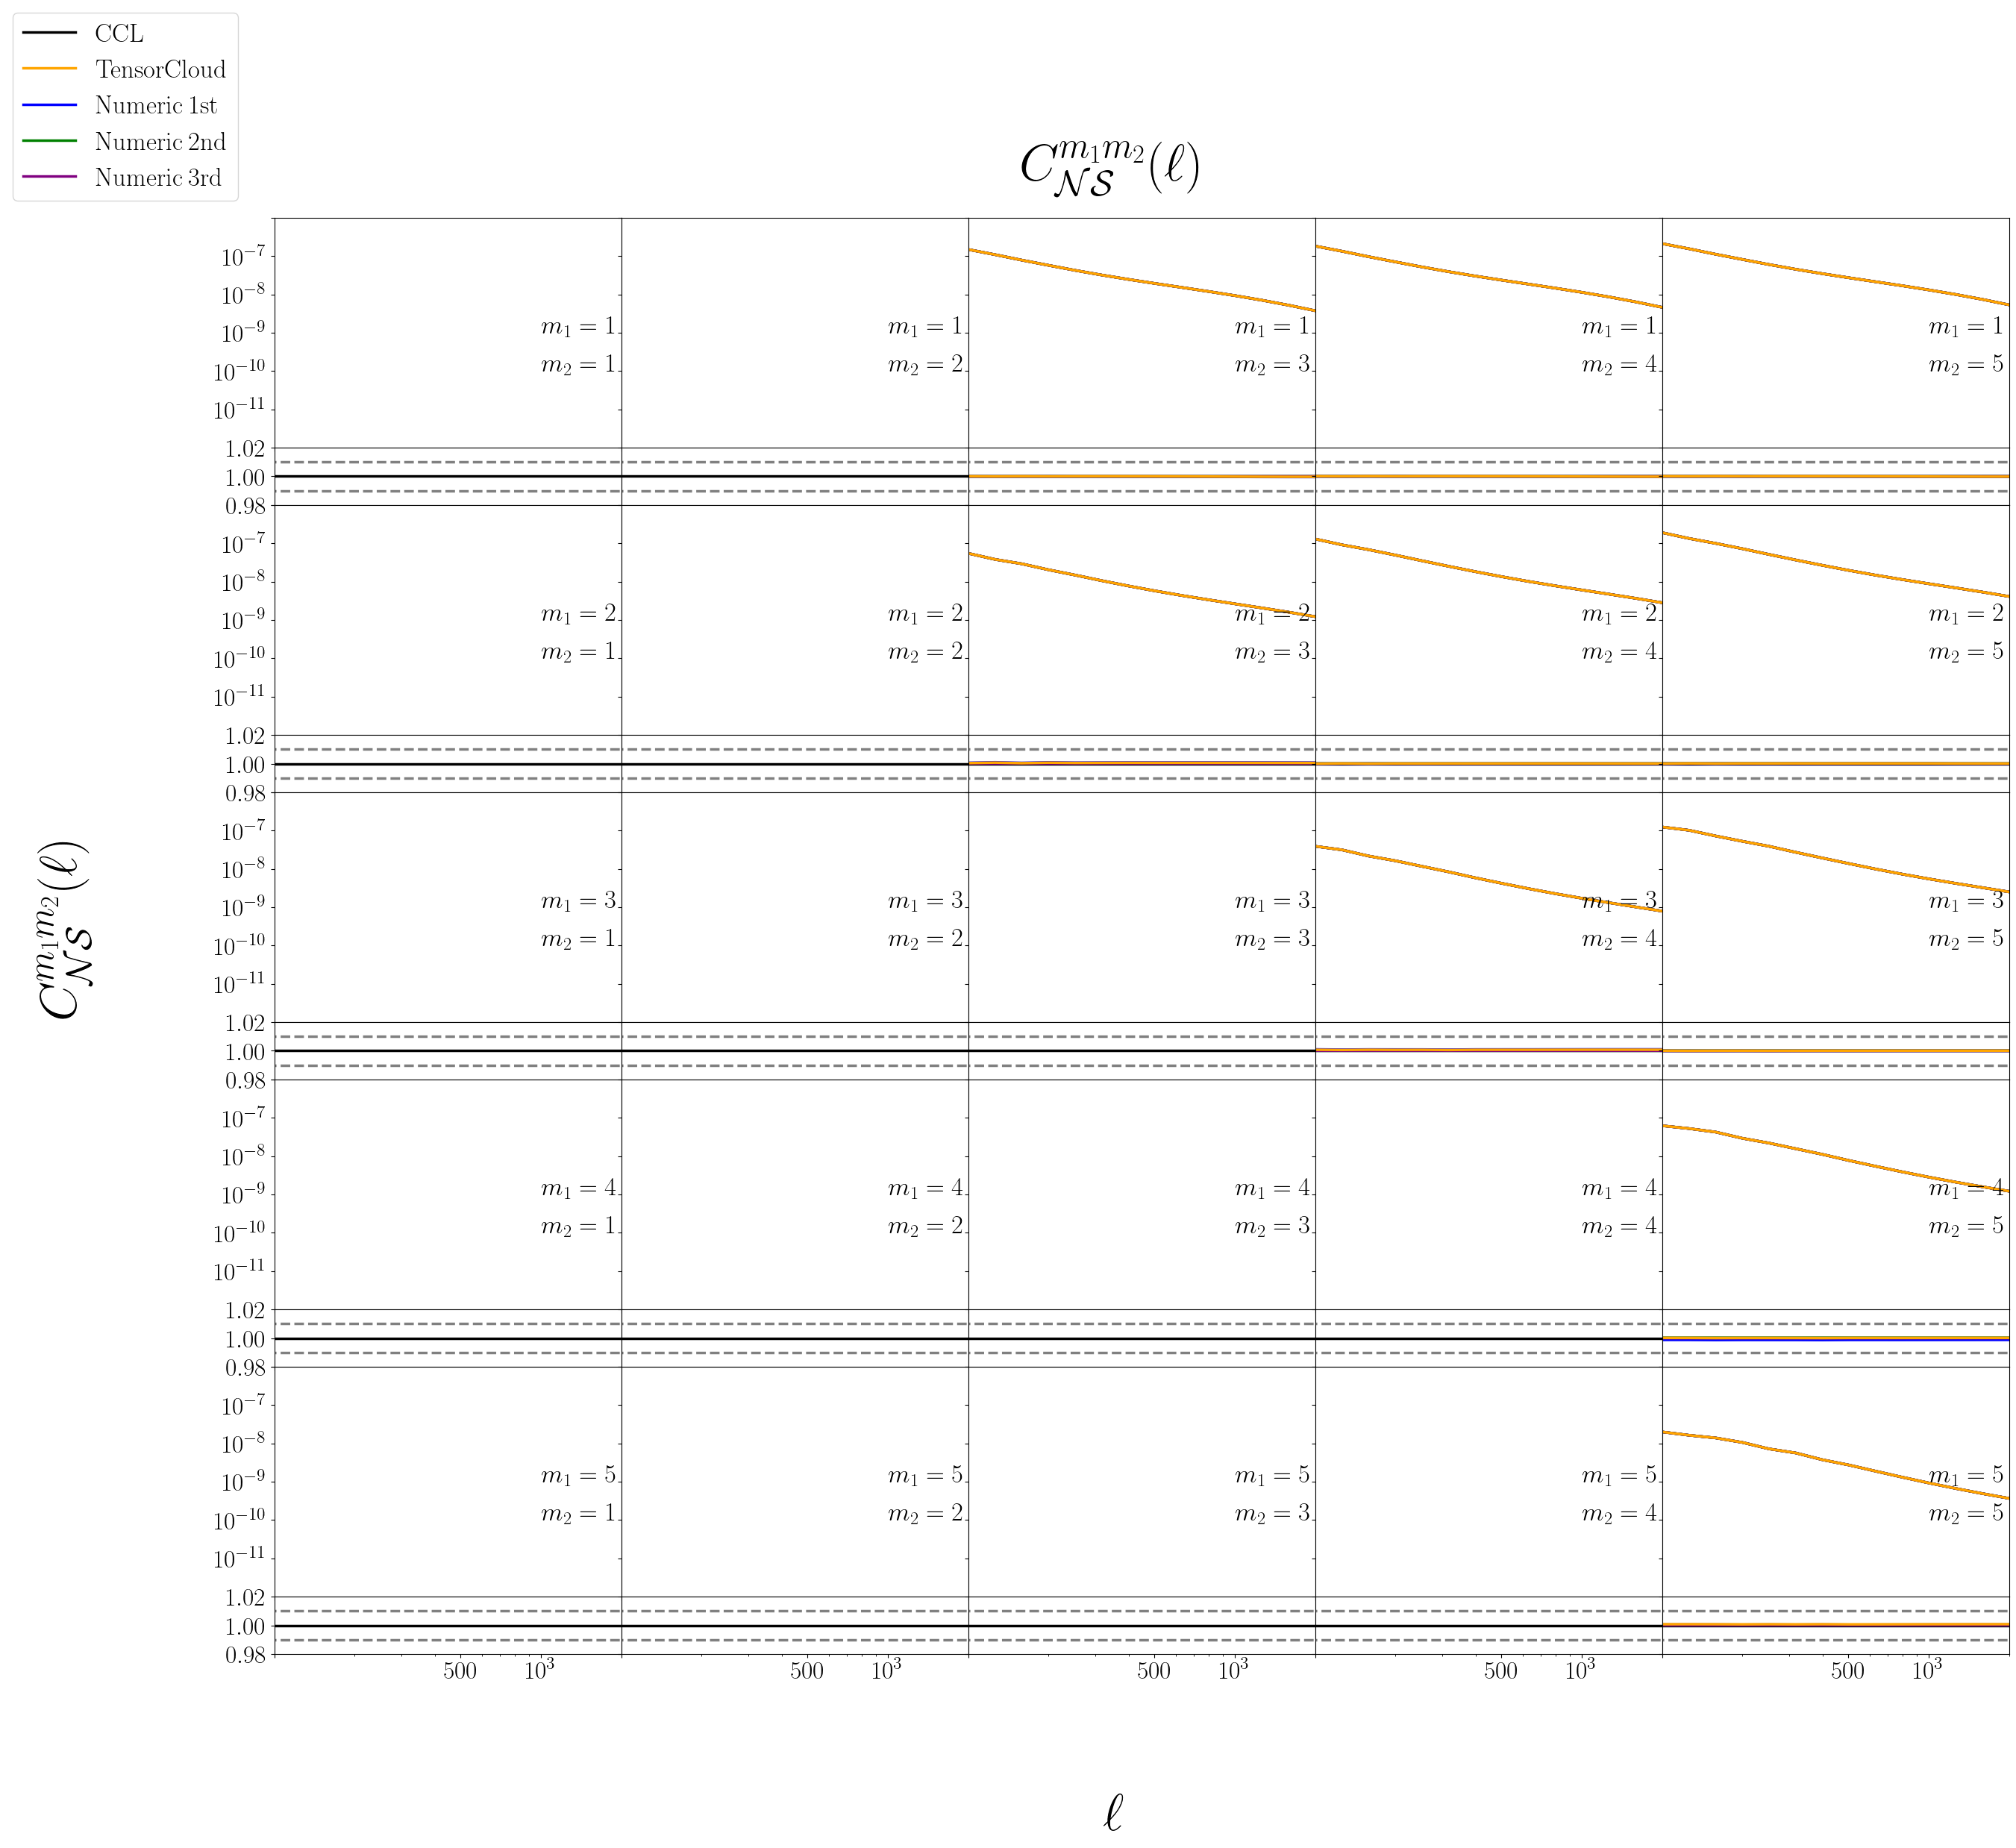

In [15]:
#Compare different bins
pyplot.rcParams['font.size'] = 24
pyplot.rcParams['text.usetex'] = True
FIGURE = pyplot.figure(figsize = (bin_lens_size * 6, bin_source_size * 5))
GRIDSPEC = GridSpec(5 * bin_lens_size, 6 * bin_source_size, figure = FIGURE, wspace = 0.0, hspace = 0.0)

for (BIN_INDEX1, BIN_INDEX2) in product(range(bin_lens_size), range(bin_source_size)):
    
    PLOT = FIGURE.add_subplot(GRIDSPEC[5 * BIN_INDEX1: 5 * BIN_INDEX1 + 4, 6 * BIN_INDEX2: 6 * BIN_INDEX2 + 6])

    if bin_lens[BIN_INDEX1 + 1] < (bin_source[BIN_INDEX2] + bin_source[BIN_INDEX2 + 1]) / 2:

        PLOT.plot(ell_grid, C_CCL[BIN_INDEX1, BIN_INDEX2,:], color = 'black', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{CCL}$')
    
        PLOT.plot(ell_grid, C_DATA1[BIN_INDEX1, BIN_INDEX2,:], color = 'blue', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 1st}$')
    
        PLOT.plot(ell_grid, C_DATA2[BIN_INDEX1, BIN_INDEX2,:], color = 'green', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 2nd}$')
        
        PLOT.plot(ell_grid, C_DATA3[BIN_INDEX1, BIN_INDEX2,:], color = 'purple', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 3rd}$')
    
        PLOT.plot(ell_grid, C_DATA[BIN_INDEX1, BIN_INDEX2,:], color = 'orange', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{TensorCloud}$')

    PLOT.text(x = 10**3, y = 10**-9, s = r'$m_1= {:.0f}$'.format(BIN_INDEX1 + 1), fontsize = 25)

    PLOT.text(x = 10**3, y = 10**-10, s = r'$m_2 = {:.0f}$'.format(BIN_INDEX2 + 1), fontsize = 25)

    PLOT.set_yscale('log')
    PLOT.set_xscale('log')
    PLOT.set_xlim(100, 2000)
    PLOT.set_ylim(10**-12, 10**-6)
    PLOT.yaxis.set_major_locator(FixedLocator([10**-6,10**-7,10**-8, 10**-9, 10**-10, 10**-11]))
    PLOT.yaxis.set_major_formatter(FixedFormatter([r'',r'${10}^{-7}$', r'${10}^{-8}$', r'${10}^{-9}$', r'${10}^{-10}$', r'${10}^{-11}$']))
    if BIN_INDEX2 > 0: PLOT.set_yticklabels([])
    
    PLOT.set_xticklabels([])
    PLOT.get_yticklabels()[0].set_visible([])

    PLOT = FIGURE.add_subplot(GRIDSPEC[BIN_INDEX1 * 5 + 4: BIN_INDEX1 * 5 + 5, BIN_INDEX2 * 6: BIN_INDEX2 * 6 + 6])

    PLOT.plot(ell_grid, numpy.ones(ell_size + 1), color = 'black', linestyle = '-', linewidth = 2.5)

    PLOT.plot(ell_grid, numpy.ones(ell_size + 1) * (1.00 + 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

    PLOT.plot(ell_grid, numpy.ones(ell_size + 1) * (1.00 - 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

    if bin_lens[BIN_INDEX1 + 1] < (bin_source[BIN_INDEX2] + bin_source[BIN_INDEX2 + 1]) / 2:

        PLOT.plot(ell_grid, C_RATIO1[BIN_INDEX1, BIN_INDEX2,:], color = 'blue', linestyle = '-', linewidth = 2.5)
    
        PLOT.plot(ell_grid, C_RATIO2[BIN_INDEX1, BIN_INDEX2,:], color = 'green', linestyle = '-', linewidth = 2.5)
        
        PLOT.plot(ell_grid, C_RATIO3[BIN_INDEX1, BIN_INDEX2,:], color = 'purple', linestyle = '-', linewidth = 2.5)
     
        PLOT.plot(ell_grid, C_RATIO[BIN_INDEX1, BIN_INDEX2,:], color = 'orange', linestyle = '-', linewidth = 2.5)

    PLOT.set_xscale('log')
    PLOT.set_xlim(100, 2000)
    PLOT.set_ylim(0.98, 1.02)
    PLOT.xaxis.set_major_locator(FixedLocator([100, 500, 1000]))
    PLOT.xaxis.set_major_formatter(FixedFormatter([r'$100$', r'$500$', r'${10}^3$']))

    if BIN_INDEX1 < bin_lens_size - 1: PLOT.set_xticklabels([])
    if BIN_INDEX2 > 0: PLOT.set_yticklabels([])
    PLOT.get_xticklabels()[0].set_visible([])
legend_handles = [
    mlines.Line2D([], [], color='black', linestyle='-', linewidth=2.5, label=r'$\mathrm{CCL}$'),
    mlines.Line2D([], [], color='orange', linestyle='-', linewidth=2.5, label=r'$\mathrm{TensorCloud}$'),
    mlines.Line2D([], [], color='blue', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 1st}$'),
    mlines.Line2D([], [], color='green', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 2nd}$'),
    mlines.Line2D([], [], color='purple', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 3rd}$')
]

FIGURE.legend(handles=legend_handles, loc='upper left', fontsize=25)
FIGURE.suptitle(r'$C^{m_1 m_2}_\mathcal{NS} (\ell)$', fontsize=50, y=0.92)
FIGURE.supxlabel(r'$\ell$', fontsize = 50)
FIGURE.supylabel(r'$C^{m_1 m_2}_\mathcal{NS} (\ell)$', fontsize = 50)

FIGURE.subplots_adjust(hspace = 0.0, wspace = 0.0)
FIGURE.show()

In [16]:
#Rebinning
def compute_cell_block(cell_grid, ell_grid):
    N_bin1 = cell_grid.shape[0]
    N_bin2 = cell_grid.shape[1]
    N_ell = cell_grid.shape[2]
    
    log_ell = numpy.log(ell_grid)
    normalized_grid = numpy.zeros((N_bin1, N_bin2, N_ell - 1))  
    new_ell_grid = 0.5 * (ell_grid[:-1] + ell_grid[1:])

    for i in range(N_bin1):
        for j in range(N_bin2):
            y = ell_grid * cell_grid[i, j, :]
            spline = scipy.interpolate.CubicSpline(x=log_ell, y=y, bc_type='natural', extrapolate=True)

            for k in range(N_ell - 1):
                log_lmin = numpy.log(ell_grid[k])
                log_lmax = numpy.log(ell_grid[k + 1])
                delta_ell = ell_grid[k + 1] - ell_grid[k]

                val = spline.integrate(log_lmin, log_lmax) / delta_ell
                normalized_grid[i, j, k] = val

    return normalized_grid,new_ell_grid



C_CCL_rebinned, ell_grid_rebinned=compute_cell_block(C_CCL, ell_grid)
C_DATA_rebinned, ell_grid_rebinned=compute_cell_block(C_DATA, ell_grid)
C_DATA1_rebinned, ell_grid_rebinned=compute_cell_block(C_DATA1, ell_grid)
C_DATA2_rebinned, ell_grid_rebinned=compute_cell_block(C_DATA2, ell_grid)
C_DATA3_rebinned, ell_grid_rebinned=compute_cell_block(C_DATA3, ell_grid)
C_RATIO_rebinned = numpy.divide(C_DATA_rebinned, C_CCL_rebinned, out = numpy.ones(C_CCL_rebinned.shape), where = C_CCL_rebinned > 0)
C_RATIO1_rebinned = numpy.divide(C_DATA1_rebinned, C_CCL_rebinned, out = numpy.ones(C_CCL_rebinned.shape), where = C_CCL_rebinned > 0)
C_RATIO2_rebinned = numpy.divide(C_DATA2_rebinned, C_CCL_rebinned, out = numpy.ones(C_CCL_rebinned.shape), where = C_CCL_rebinned > 0)
C_RATIO3_rebinned = numpy.divide(C_DATA3_rebinned, C_CCL_rebinned, out = numpy.ones(C_CCL_rebinned.shape), where = C_CCL_rebinned > 0)

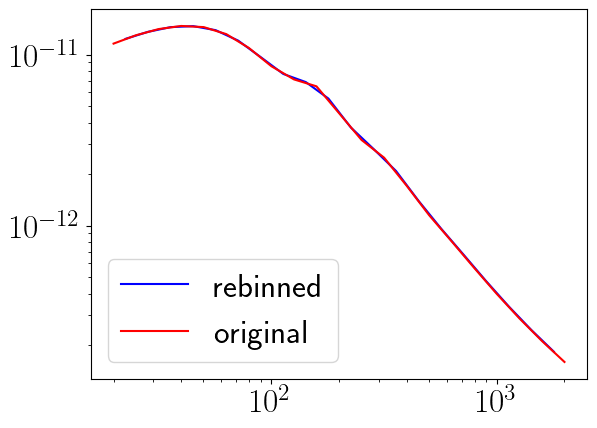

In [17]:
import matplotlib.pyplot as plt
plt.plot(ell_grid_rebinned,C_CCL_rebinned[3][2], color = 'blue',label='rebinned')
plt.plot(ell_grid,C_CCL[3][2], color = 'red',label='original')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [18]:
#diagonal covariance
k_maximal_lens = 0.1 * cosmology_info['H']
ell_maximal_lens = k_maximal_lens * pyccl.comoving_radial_distance(cosmo=cosmology, a=1 / (1 + bin_lens)) - 1 / 2

# Covariance
cell_range1 = bin_lens_size * (bin_lens_size + 1) // 2 * ell_size
cell_range2 = cell_range1 + bin_lens_size * bin_source_size * ell_size

covariance = numpy.loadtxt(os.path.join(cell_folder, '{}/COVARIANCE/COVARIANCE_MATRIX_{}.ascii'.format(tag, label)), dtype=numpy.float32)
variance = numpy.diagonal(covariance, axis1=0, axis2=1)
sigma = numpy.sqrt(variance)[cell_range1: cell_range2]



sigma_matrix = numpy.zeros((bin_lens_size, bin_source_size, ell_size))
idx = 0
for m in range(bin_lens_size):
    for n in range(m, bin_source_size):
        seg = sigma[idx*ell_size:(idx+1)*ell_size]    
        sigma_matrix[m, n, :] = seg
        sigma_matrix[n, m, :] = seg
        idx += 1
cell_DATA_zeta = numpy.divide(numpy.abs(C_DATA_rebinned - C_CCL_rebinned), sigma_matrix, out=numpy.zeros_like(sigma_matrix), where=sigma_matrix != 0)
cell_DATA1_zeta = numpy.divide(numpy.abs(C_DATA1_rebinned - C_CCL_rebinned), sigma_matrix, out=numpy.zeros_like(sigma_matrix), where=sigma_matrix != 0)
cell_DATA2_zeta = numpy.divide(numpy.abs(C_DATA2_rebinned - C_CCL_rebinned), sigma_matrix, out=numpy.zeros_like(sigma_matrix), where=sigma_matrix != 0)
cell_DATA3_zeta = numpy.divide(numpy.abs(C_DATA3_rebinned - C_CCL_rebinned), sigma_matrix, out=numpy.zeros_like(sigma_matrix), where=sigma_matrix != 0)

In [19]:
#redshift variance
with h5py.File(os.path.join(cell_folder, '{}/{}/{}_DATA_{}.hdf5'.format(tag, name, typ, label)), 'r') as file:
    cell_data = file['data'][...]
cell_data_error = numpy.std(cell_data, axis = 0)
#sigma_all = sigma_matrix + cell_data_error 
sigma_all = numpy.sqrt(sigma_matrix**2 + cell_data_error**2)# /sqrt(a^2+b^2)

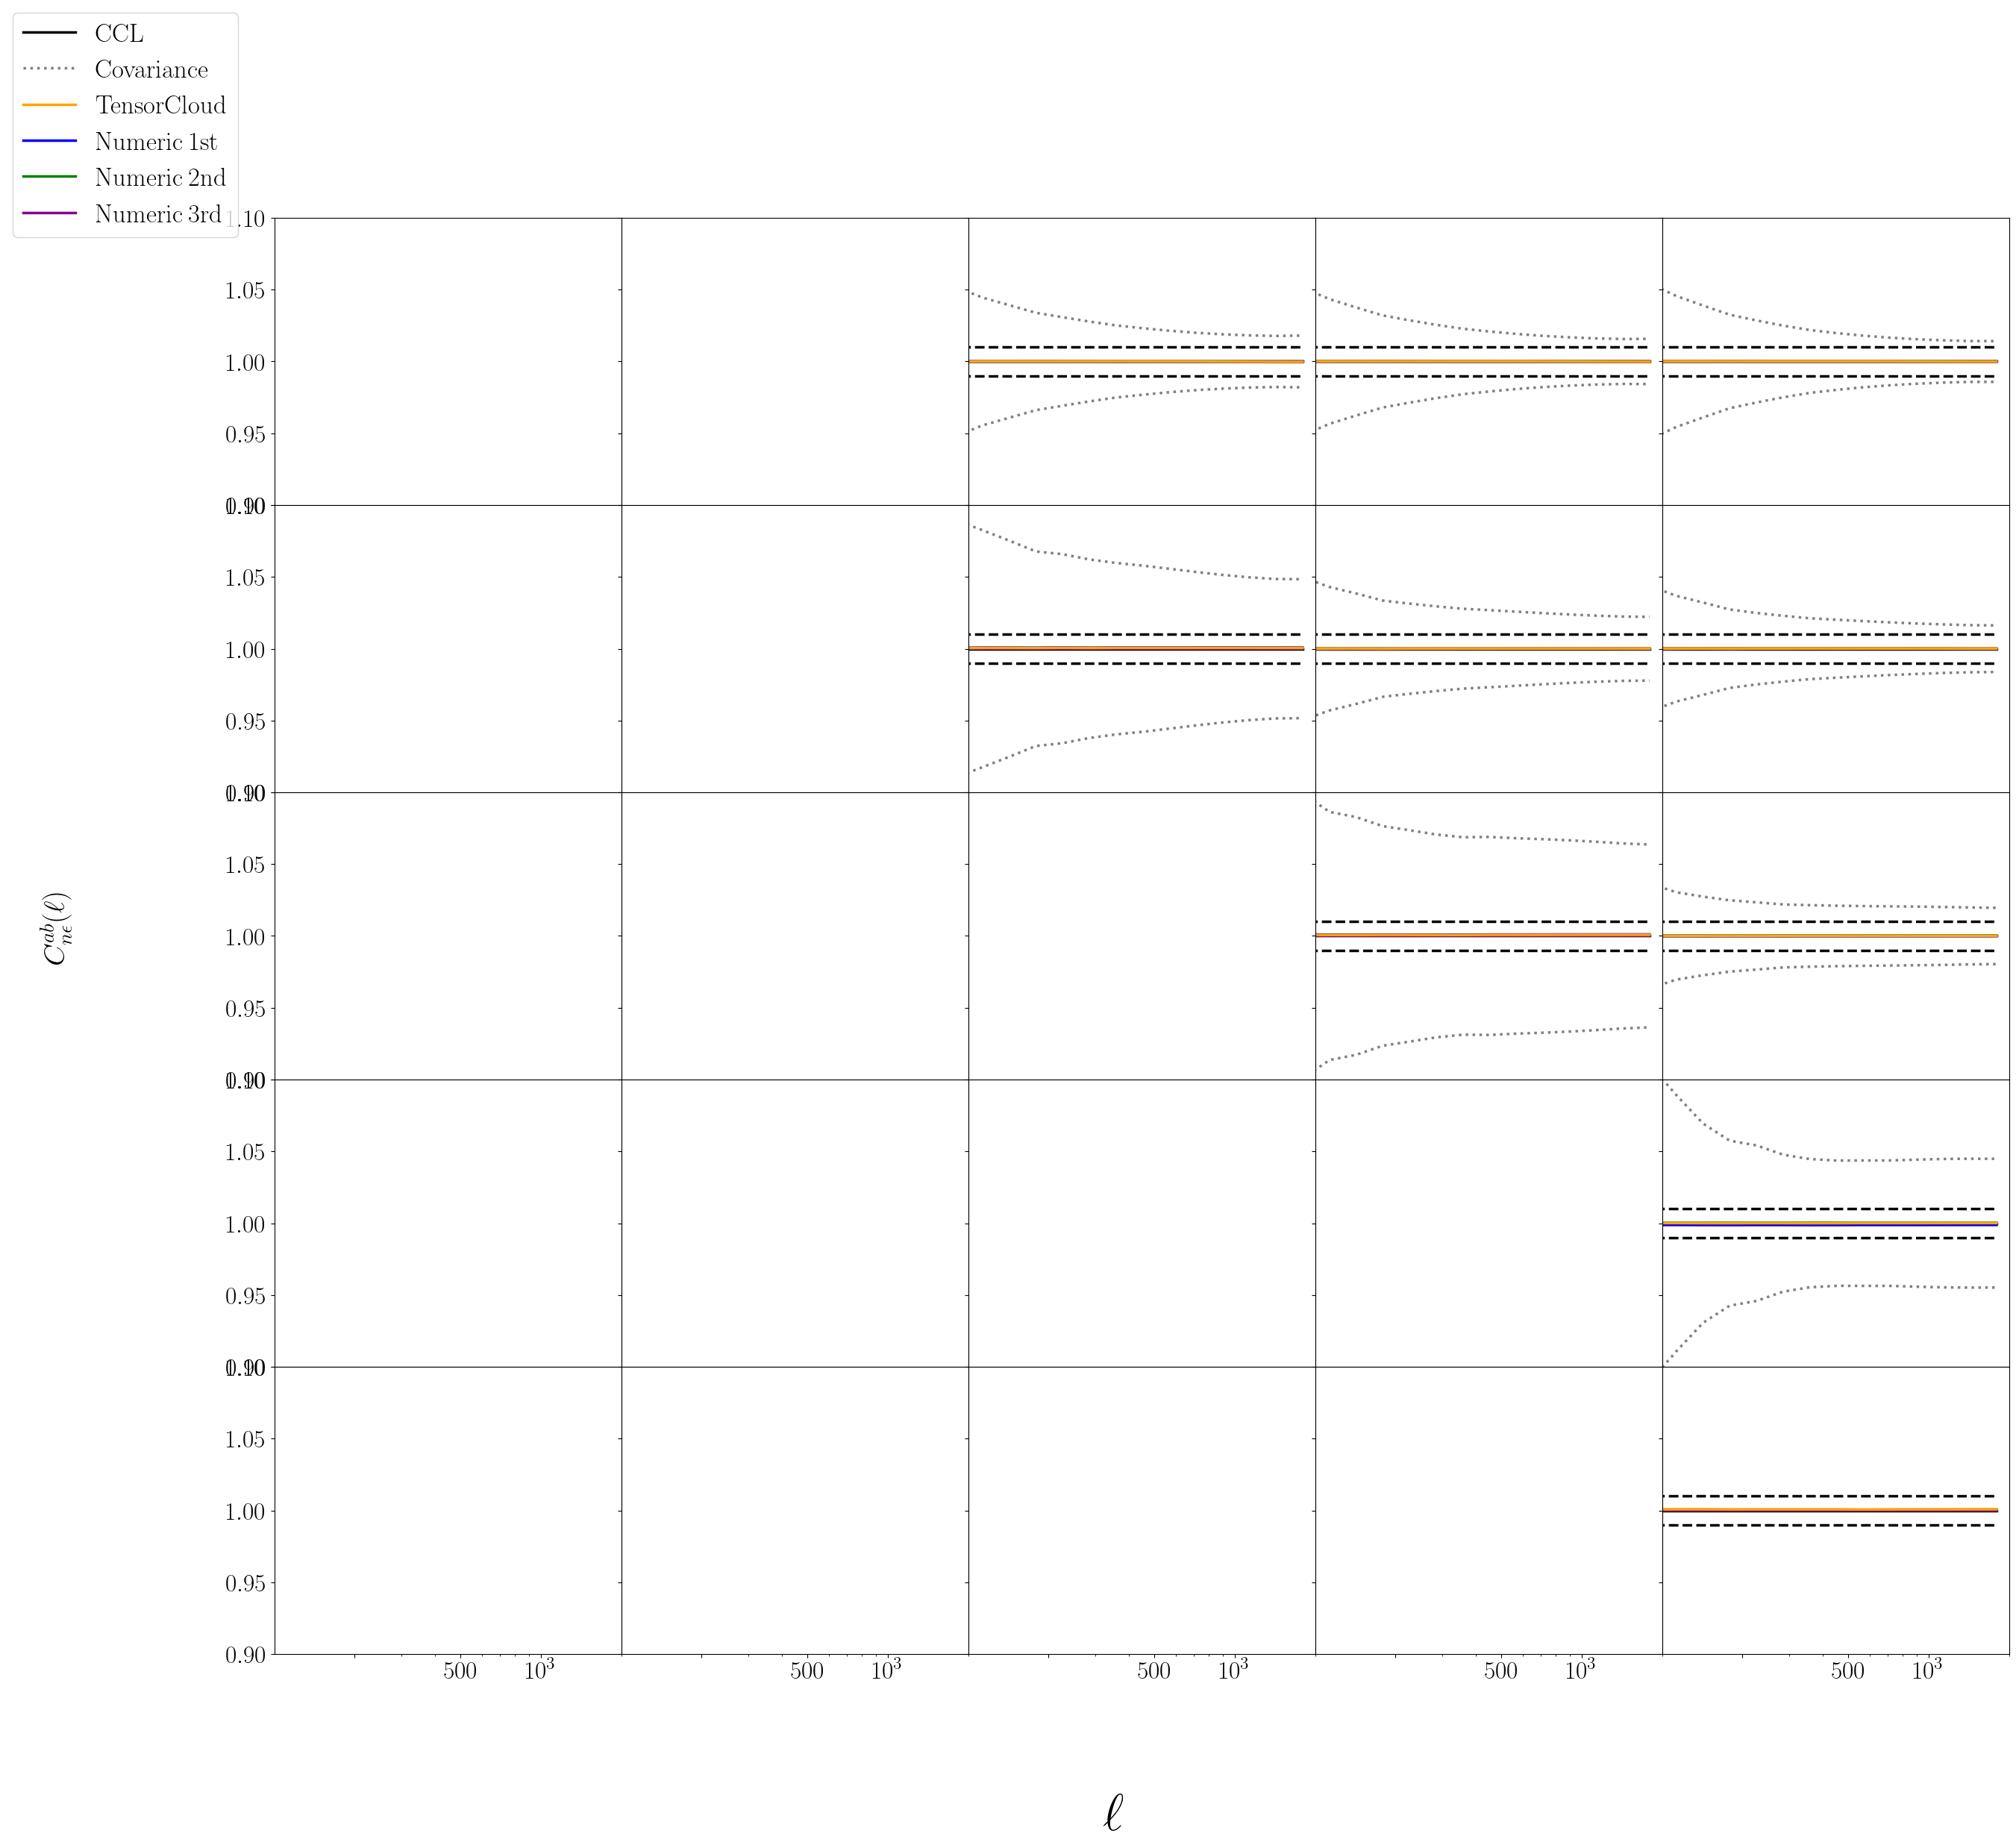

In [20]:
#Compare different bins(After rebinning)
pyplot.rcParams['font.size'] = 24
pyplot.rcParams['text.usetex'] = True
FIGURE = pyplot.figure(figsize = (bin_lens_size * 6, bin_source_size * 5))
GRIDSPEC = GridSpec(5 * bin_lens_size, 6 * bin_source_size, figure = FIGURE, wspace = 0.0, hspace = 0.0)

for (BIN_INDEX1, BIN_INDEX2) in product(range(bin_lens_size), range(bin_source_size)):

    PLOT = FIGURE.add_subplot(GRIDSPEC[BIN_INDEX1 * 5: BIN_INDEX1 * 5 + 5, BIN_INDEX2 * 6: BIN_INDEX2 * 6 + 6])
    if bin_lens[BIN_INDEX1 + 1] < (bin_source[BIN_INDEX2] + bin_source[BIN_INDEX2 + 1]) / 2:

        PLOT.plot(ell_grid_rebinned, numpy.ones(ell_size), color = 'black', linestyle = '-', linewidth = 2.5)
    
        PLOT.plot(ell_grid_rebinned, numpy.ones(ell_size) * (1.00 + 0.01), color = 'black', linestyle = '--', linewidth = 2.5)
        
        PLOT.plot(ell_grid_rebinned, numpy.ones(ell_size) * (1.00 - 0.01), color = 'black', linestyle = '--', linewidth = 2.5)

        PLOT.plot(ell_grid_rebinned, numpy.ones(ell_size)+ sigma_matrix[BIN_INDEX1, BIN_INDEX2, :] / C_CCL_rebinned[BIN_INDEX1, BIN_INDEX2, :], color = 'grey', linestyle = ':', linewidth = 2.5)
    
        PLOT.plot(ell_grid_rebinned, numpy.ones(ell_size)- sigma_matrix[BIN_INDEX1, BIN_INDEX2, :] / C_CCL_rebinned[BIN_INDEX1, BIN_INDEX2, :], color = 'grey', linestyle = ':', linewidth = 2.5)

        PLOT.plot(ell_grid_rebinned, C_RATIO1_rebinned[BIN_INDEX1, BIN_INDEX2,:], color = 'blue', linestyle = '-', linewidth = 2.5)
    
        PLOT.plot(ell_grid_rebinned, C_RATIO2_rebinned[BIN_INDEX1, BIN_INDEX2,:], color = 'green', linestyle = '-', linewidth = 2.5)
        
        PLOT.plot(ell_grid_rebinned, C_RATIO3_rebinned[BIN_INDEX1, BIN_INDEX2,:], color = 'darkmagenta', linestyle = '-', linewidth = 2.5)
     
        PLOT.plot(ell_grid_rebinned, C_RATIO_rebinned[BIN_INDEX1, BIN_INDEX2,:], color = 'orange', linestyle = '-', linewidth = 2.5)

    PLOT.set_xscale('log')
    PLOT.set_xlim(100, 2000)
    PLOT.set_ylim(0.9, 1.1)
    PLOT.xaxis.set_major_locator(FixedLocator([200, 500, 1000]))
    PLOT.xaxis.set_major_formatter(FixedFormatter([r'$200$', r'$500$', r'${10}^3$']))

    if BIN_INDEX1 < bin_lens_size - 1: PLOT.set_xticklabels([])
    if BIN_INDEX2 > 0: PLOT.set_yticklabels([])
    PLOT.get_xticklabels()[0].set_visible([])
legend_handles = [
    mlines.Line2D([], [], color='black', linestyle='-', linewidth=2.5, label=r'$\mathrm{CCL}$'),
    mlines.Line2D([], [], color='grey', linestyle=':', linewidth=2.5, label=r'$\mathrm{Covariance}$'),
    mlines.Line2D([], [], color='orange', linestyle='-', linewidth=2.5, label=r'$\mathrm{TensorCloud}$'),
    mlines.Line2D([], [], color='blue', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 1st}$'),
    mlines.Line2D([], [], color='green', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 2nd}$'),
    mlines.Line2D([], [], color='darkmagenta', linestyle='-', linewidth=2.5, label=r'$\mathrm{Numeric \: 3rd}$')
]

FIGURE.legend(handles=legend_handles, loc='upper left', fontsize=25)
#FIGURE.suptitle(r'$C^{m_1 m_2}_\mathcal{NS} (\ell)$', fontsize=50, y=0.92)
FIGURE.supxlabel(r'$\ell$', fontsize = 50)
FIGURE.supylabel(r'$C_{n \epsilon}^{ab} (\ell)$')


FIGURE.subplots_adjust(hspace = 0.0, wspace = 0.0)
FIGURE.savefig('Cneps-Y1-cov.png')
FIGURE.show()

In [21]:
print(sigma_matrix[4, 4, :] / C_CCL_rebinned[4, 4, :])

[3.16252709 2.30824124 1.58491014 1.05514427 0.76859717 0.57892463
 0.44968014 0.36917973 0.28066222 0.20465808 0.18847446 0.16267291
 0.14417449 0.14099694 0.13415323 0.13693387 0.14077013 0.14556526
 0.14946389 0.15237072]
